# Practical MCMC in Python


## Introduction

In this notebook, we'll implement a Markov Chain Monte Carlo (MCMC) algorithm and demonstrate its use on two realistic simulated datasets. First, we'll fit a line to a set of data points with Gaussian uncertainties in one dimension. This problem should *never* be done using MCMC in practice—the solution is analytic!—but it is useful as a functional test of the code and as a demonstration of the concepts. Next, we'll fit a power law model to a set of entries in a catalog assuming a Poisson likelihood function. This problem is very relevant to this meeting for a few reasons but we'll come back to that later.

This worksheet is written in Python and it lives in an IPython notebook. In this context, you'll be asked to write a few lines of code to implement the sampler and the models but much of the boilerplate code is already in place. Therefore, even if you're not familiar with Python, you should be able to get something out of the notebook. I don't expect that everyone will finish the full notebook but that's fine because it has been designed to get more difficult as we progress.

## How to use the notebook

*If you're familiar with IPython notebooks, you can probably skip this section without missing anything.*

IPython notebooks work by running a fully functional Python sever behind the scenes and if you're reading this then you probably already figured out how to get that running. Then, inside the notebook, the content is divided into cells containing code or text.

You'll be asked to edit a few of the cells below to add your own code. To do this, click on the cell to start editing and then type as you normally would. To execute the code contained in the cell, press `Shift-Enter`. Even for existing cells that you don't need to edit, you should select them and type `Shift-Enter` when you get there because the cells below generally depend on the previous cells being executed first.

To get started, edit the cell below to assign your name (or whatever you want) to the variable `name` and then press `Shift-Enter` to exectue the cell.

In [3]:
name = "YOUR NAME HERE"
print("Hello {0}!".format(name))

Hello YOUR NAME HERE!


If this works, the output should greet you without throwing any errors. If so, that's pretty much all we need so let's get started with some MCMC!

## Dataset 1: Fitting a line to data

Today, we're going to implement the simplest possible MCMC algorithm but before we do that, we'll need some data to test our method with.

### Load the data

I've generated a simulated dataset generated from a linear model with no uncertainties in the $x$ dimension and known Gaussian uncertainties in the $y$ dimension. These data are saved in the CSV file `linear.csv` included with this notebook.

First we'll need `numpy` and `matplotlib` so let's import them:

In [53]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100  # This makes all the plots a little bigger.
import numpy as np
import matplotlib.pyplot as plt

Now we'll load the datapoints and plot them. When you execute the following cell, you should see a plot of the data. If not, make sure that you run the import cell from above first.

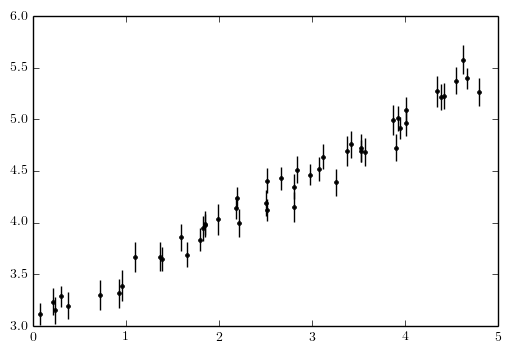

In [54]:
# Load the data from the CSV file.
x, y, yerr = np.loadtxt("linear.csv", delimiter=",", unpack=True)

# Plot the data with error bars.
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlim(0, 5);

As I mentioned previously, it is pretty silly to use MCMC to solve this problem because the maximum likelihood and full posterior probability distribution (under infinitely broad priors) for the slope and intercept of the line are known analytically. Therefore, let's compute what the right answer should be before we even start. The analytic result for the posterior probability distribution is a 2-d Gaussian with mean

$$\mathbf{w} = \left(\begin{array}{c}
    m \\ b
\end{array}\right) = (\mathbf{A}^\mathrm{T}\,C^{-1}\mathbf{A})^{-1} \, \mathbf{A}^\mathrm{T}\,C^{-1}\,\mathbf{y}$$

and covariance matrix

$$\mathbf{V} = (\mathbf{A}^\mathrm{T}\,C^{-1}\mathbf{A})^{-1}$$

where

$$\mathbf{y} = \left(\begin{array}{c}
y_1 \\ y_2 \\ \vdots \\ y_N
\end{array}\right) \quad , \quad \mathbf{A} = \left(\begin{array}{cc}
x_1 & 1 \\ x_2 & 1 \\ \vdots & \vdots \\ x_N & 1
\end{array}\right) \quad ,\, \mathrm{and} \quad
\mathbf{C} = \left(\begin{array}{cccc}
\sigma_1^2 & 0 & \cdots & 0 \\
0 & \sigma_2^2 & \cdots & 0 \\
&&\ddots& \\
0 & 0 & \cdots & \sigma_N^2
\end{array}\right)$$

There are various functions in Python for computing this but I prefer to do it myself (it only takes a few lines of code!) and here it is:

In [55]:
A = np.vander(x, 2)  # Take a look at the documentation to see what this function does!
ATA = np.dot(A.T, A / yerr[:, None]**2)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
V = np.linalg.inv(ATA)

We'll save these results for later to compare them to the result computed using MCMC but for now, it's nice to take a look and see what this prediction looks like. To do this, we'll sample 24 slopes and intercepts from this 2d Gaussian and overplot them on the data.

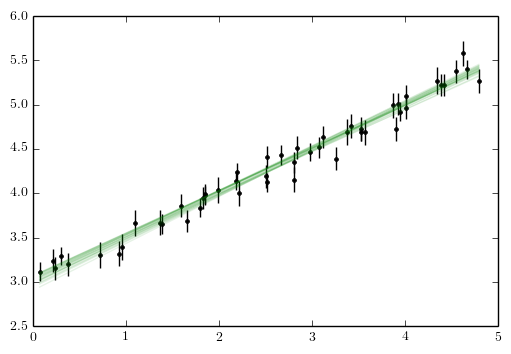

In [56]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
for m, b in np.random.multivariate_normal(w, V, size=24):
    plt.plot(x, m*x + b, "g", alpha=0.1)
plt.xlim(0, 5);

This plot is a visualization of our posterior expectations for the *true* underlying line that generated these data. We'll reuse this plot a few times later to test the results of our code.

### The probabilistic model

In order use MCMC to perform posterior inference on a model and dataset, we need a function that computes the value of the posterior probability given a proposed setting of the parameters of the model. For reasons that will become clear below, we actually only need to return a value that is *proportional* to the probability.

As discussed in a previous tutorial, the posterior probability for parameters $\mathbf{w} = (m,\,b)$ conditioned on a dataset $\mathbf{y}$ is given by

$$p(\mathbf{w} \,|\, \mathbf{y}) = \frac{p(\mathbf{y} \,|\, \mathbf{w}) \, p(\mathbf{w})}{p(\mathbf{y})}$$

where $p(\mathbf{y} \,|\, \mathbf{w})$ is the *likelihood* and $p(\mathbf{w})$ is the *prior*. For this example, we're modeling the likelihood by assuming that the datapoints are independent with known Gaussian uncertainties $\sigma_n$. This specifies a likelihood function:

$$p(\mathbf{y} \,|\, \mathbf{w}) = \prod_{n=1}^N \frac{1}{\sqrt{2\,\pi\,\sigma_n^2}} \,
\exp \left(-\frac{[y_n - f_\mathbf{w}(x_n)]^2}{2\,\sigma_n^2}\right)$$

where $f_\mathbf{w}(x) = m\,x + b$ is the linear model.

For numerical reasons, we will acutally want to compute the logarithm of the likelihood. In this case, this becomes:

$$\ln p(\mathbf{y} \,|\, \mathbf{w}) = -\frac{1}{2}\sum_{n=1}^N \frac{[y_n - f_\mathbf{w}(x_n)]^2}{\sigma_n^2} + \mathrm{constant} \quad.$$

In the following cell, replace the contents of the `lnlike_linear` function to implement this model. The function takes two values (`m` and `b`) as input and it should return the log likelihood (a single number) up to a constant. In this function, you can just use the globaly defined dataset `x`, `y` and `yerr`. For performance, I recommend using vectorized numpy operations (the key function will be `np.sum`).

In [57]:
def lnlike_linear((m, b)):
    # CODE HERE
    f = m*x + b
    return -0.5 * np.sum(((y-f) / yerr) ** 2)

After you're satisfied with your implementation, run the following cell. In this cell, we're checking to see if your code is right. If it is, you'll see a smiling face (☺︎) but if not, you'll get an error message.

In [58]:
p_1, p_2 = (0.0, 0.0), (0.01, 0.01)
ll_1, ll_2 = lnlike_linear(p_1), lnlike_linear(p_2)
if not np.allclose(ll_2 - ll_1, 535.8707738280209):
    raise ValueError("It looks like your implementation is wrong!")
print("☺︎")

☺︎


If you don't get the ☺︎, go back and try to debug your model. Iterate until your result is correct.

Once you get that, we'll use this to implement the full model (*Remember: we haven't added in the prior yet*). For the purposes of this demonstration, we'll assume infinitely broad uniform priors on both $m$ and $b$. This isn't generally a good idea... instead, you should always apply some sort of prior constraint that

**FINISH THIS**

In [59]:
def lnprior_linear((m, b)):
    if not (-10 < m < 10):
        return -np.inf
    if not (-10 < b < 10):
        return -np.inf
    return 0.0

In [60]:
def lnpost_linear(theta):
    return lnprior_linear(theta) + lnlike_linear(theta)

### Metropolis(–Hastings) MCMC

The simplest MCMC algorithm is generally referred to as the Metropolis method. All MCMC algorithms work by specifying a "step" that moves from one position in parameter space to another with some probability. The Metropolis step takes a position $\theta_t$ (a vector containing the slope and intercept at step $t$) to the position $\theta_{t+1}$ using the following steps:

1. propose a new position $\mathbf{q}$ drawn from a Gaussian centered on the current position $\theta_t$
2. compute the probability of the new position $p(\mathbf{q}\,|\,\mathbf{y})$
3. draw a random number $r$ between 0 and 1 and if
$$r < \frac{p(\mathbf{q}\,|\,\mathbf{y})}{p(\mathbf{x}_t\,|\,\mathbf{y})}$$
return $\mathbf{q}$ as $\theta_{t+1}$ and, otherwise, return $\theta_t$ as $\theta_{t+1}$.

In the following cell, you'll implement this step. The function will take 4 arguments:

1. a function that computes the ln-probability (for this demo, it'll be `lnpost_linear` from above),
2. the current position $\theta_t$,
3. the ln-probability at the current point $p(\theta_t\,|\,\mathbf{y})$, and
4. the covariance matrix of the Gaussian proposal distribution.

It should return two values, the new coordinate $\theta_{t+1}$ and the ln-probability at that point $p(\theta_{t+1}\,|\,\mathbf{y})$. The syntax for returning multiple values is `return a, b`.

This function is really the key to this whole tutorial so spend some time getting it right! It is hard to robustly test functions with a random component so chat with other people around you to check your method. We'll also try to test it below but it's worth spending some time now.

There are a few functions that will come in handy here but the two most important ones are:

- `np.random.multivariate_normal(theta_t, step_cov)` - draws a vector sample from the multivariate Gaussian centered on `theta_t` with covariance matrix `step_cov`.
- `np.random.rand()` - draws a random number between 0 and 1.

In [61]:
def metropolis_step(lnpost_function, theta_t, lnpost_t, step_cov):
    # CODE HERE
    q = np.random.multivariate_normal(theta_t, step_cov)
    lp1 = lnpost_function(q)
    if lp1 - lnpost_t > np.log(np.random.rand()):
        return q, lp1
    return theta_t, lnpost_t

As before, here's a simple test for this function. When you run the following cell it will either print a smile or throw an exception. Since the algorithm is random, it might occasionally fail this test so if it fails once, try running it again. If it fails a second time, edit your implementation until the test consistently passes.

In [62]:
lptest = lambda x: -0.5 * np.sum(x**2)
th = np.array([0.0])
lp = 0.0
chain = np.array([th for th, lp in (metropolis_step(lptest, th, lp, [[0.3]])
                                    for _ in range(10000))])
if np.abs(np.mean(chain)) > 0.1 or np.abs(np.std(chain) - 1.0) > 0.1:
    raise ValueError("It looks like your implementation is wrong!")
print("☺︎")

☺︎


### Running the Markov Chain

Now that we have an implementation of the Metropolis step, we can go on to sample from the posterior probability density that we implemented above. To start, we need to initialize the sampler somewhere in parameter space. In the following cell, edit your guess for the slope and intercept of the line until it looks like a rasonably good fit to the data.

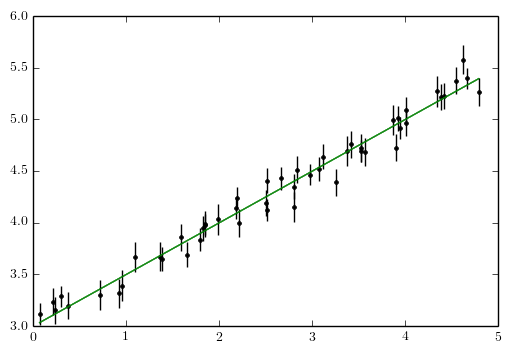

In [63]:
# Edit these guesses.
m_initial = 0.5
b_initial = 3

# You shouldn't need to change this plotting code.
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
for m, b in np.random.multivariate_normal(w, V, size=24):
    plt.plot(x, m_initial*x + b_initial, "g", alpha=0.1)
plt.xlim(0, 5);

In the next cell, we'll start from this initial guess for the slope and intercept and walk through parameter space (using the transition probability from above) to generate a Markov Chain of samples from the posterior probability.

There are a few tuning parameters for the method. The first and most important choice has already been covered: **initialization**. The practical performance of an MCMC sampler depends sensitively on the initial position so it's worth spending some time choosing a good initialization.

The second big tuning parameter is **the scale of the proposal distribution**. We must specify the covariance matrix for the proposal Gaussian. This proposal is currently set to a very bad value. Your job is to run the sampler, look at the output, and try to tune the proposal until you find a "good" value. You will judge this based on a few things. First, you can check the acceptance fraction (the fraction of accepted proposals). For this (easy!) problem, the target is around about 50% but for harder problems in higher dimensions, a good target is around 20%. Another useful diagnostic is a plot of the parameter values as a function of step number. For example, if this looks like a random walk then your proposal scale is probably too small. Once you reach a good proposal, this plot should "look converged".

The final tuning parameter is **the number of steps to take**. In theory, you need to take an infitite number of steps but we don't (ever) have time for that so instead you'll want to take a large enough number of samples so that the sampler has sufficiently explored parameter space and converged to a stationary distribution. This is, of course, unknowable so for today you'll just have to go with your intuition.

Take some time now to adjust these tuning parameters and get a sense of what happens to the sampling when you change different things.

The acceptance fraction was: 0.534


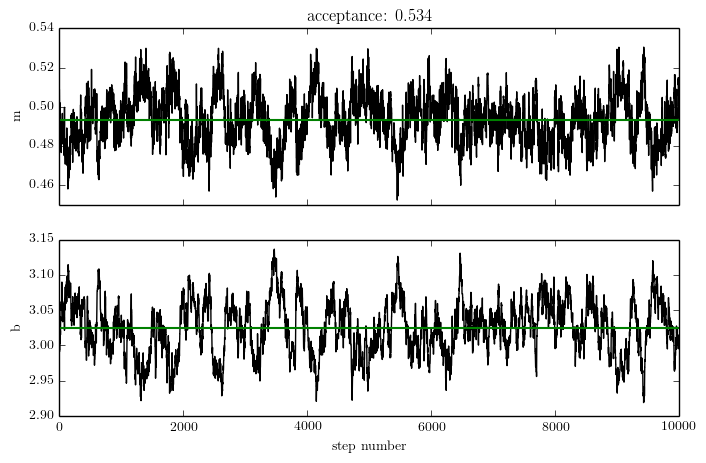

In [81]:
# Edit this line to specify the proposal covariance:
step = np.diag([1e-4, 1e-4])

# Edit this line to choose the number of steps you want to take:
nstep = 10000

# You shouldn't need to change any of the lines below here.
p0 = np.array([m_initial, b_initial])
lp0 = lnpost_linear(p0)
chain = np.empty((nstep, len(p0)))
for i in range(len(chain)):
    p0, lp0 = metropolis_step(lnpost_linear, p0, lp0, step)
    chain[i] = p0
    
# Compute the acceptance fraction.
acc = float(np.any(np.diff(chain, axis=0), axis=1).sum()) / (len(chain)-1)
print("The acceptance fraction was: {0:.3f}".format(acc))

# Plot the traces.
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
axes[0].plot(chain[:, 0], "k")
axes[0].axhline(w[0], color="g", lw=1.5)
axes[0].set_ylabel("m")
axes[1].plot(chain[:, 1], "k")
axes[1].axhline(w[1], color="g", lw=1.5)
axes[1].set_ylabel("b")
axes[1].set_xlabel("step number")
axes[0].set_title("acceptance: {0:.3f}".format(acc));

The results of the MCMC run are stored in the array called `chain` with dimensions `(nstep, 2)`. These are samples from the posterior probability density for the parameters. We know from above that this should be a Gaussian with mean $\mathbf{w}$ and covariance $\mathbf{V}$ so let's compare the sample mean and covariance to the analytic result that we computed above:

In [82]:
if np.any(np.abs(np.mean(chain, axis=0)-w)>0.01) or np.any(np.abs(np.cov(chain, rowvar=0)-V)>1e-4):
    raise ValueError("It looks like your implementation is wrong!")
print("☺︎")

☺︎


If you don't get a smile here, that could mean a few things:

- you didn't run for long enough (try increasing `nstep`),
- your choice of step scale was not good (try playing around with the definition of `step`), or
- there's a bug in your code.

Try out all of these tuning parameters until you have a good intuition for what's going on and figure out which settings pass this test and which don't.

In [102]:
# Poisson

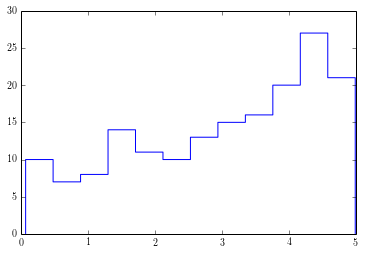

In [152]:
events = np.loadtxt("poisson.csv")
mn, mx = 0.0, 5.0
pl.hist(events, 12, histtype="step");

In [175]:
def lnprob_counts(p):
    lp = p[0] * events + p[1]
    norm = np.exp(p[1]) * (np.exp(p[0] * mx) - np.exp(p[0] * mn)) / p[0]
    return np.sum(lp) - norm

In [176]:
p0 = np.array([5, 30])
lp0 = lnprob_counts(p0)
nacc = 0
step = 1e-2 * np.eye(len(p0))

chain = np.empty((5e4, len(p0)))
lpchain = np.empty(len(chain))
for i in range(len(chain)):
    p0, lp0, acc = metropolis_step(lnprob_counts, p0, lp0, step)
    chain[i] = p0
    lpchain[i] = lp0
    nacc += acc

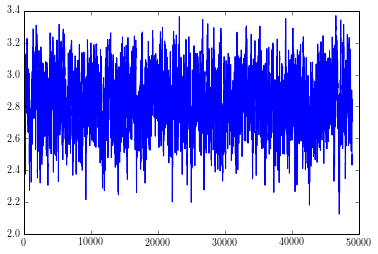

In [186]:
pl.plot(chain[1000:, 1])

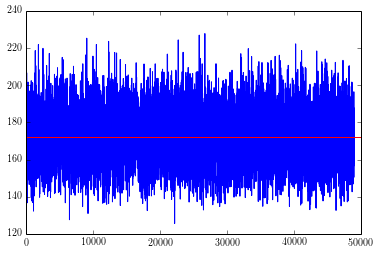

In [183]:
pl.plot(np.exp(chain[1000:, 1]) * (np.exp(chain[1000:, 0] * mx) - np.exp(chain[1000:, 0] * mn)) / chain[1000:, 0])
pl.gca().axhline(len(events), color="r")

In [182]:
len(events)

172